## **Document Document Relationship**

> - Same as Entity-Entity relationship, we will project bipartite graph on to a set of document to create a document-document network.  
> - We willl use `overlap_weighted_projected_graph` function (**Using Jaccard Similarity**) to obtain weighted graph that can be **filtered to reduce the number of significant edges**.  
> - **The Jaccard coefficient** is a measure of similarity between two sets. It can take on a value between -1 and +1 where a score

> Extracting Document from reuter into NLP model that loading using spacy, and extract keywords from gensim library and corresponding score to each keyword. here we also calculate within the score of each keyword by usingTF-IDF score algorithm.

In [84]:
from nltk.corpus import reuters
import pandas as pd
from langdetect import detect
import numpy as np
import spacy
import re

corpus = pd.DataFrame([
    {"id": _id,
     "text": reuters.raw(_id).replace("\n", ""), 
     "label": reuters.categories(_id)}
    for _id in reuters.fileids()
 ])
# corpus = corpus.loc[:4]

# Clean the Text
def clean_text(text):
    # Remove escape characters
    text = text.replace("\n", "")
    # Convert to lowercase
    text = text.lower()
    # Remove quotes around company names
    text = re.sub(r'<(.*?)>', r'\1', text)
    return text
corpus['clean_text']=corpus["text"].apply(clean_text)
# corpus["clean_text"] = corpus["text"].apply(
#     lambda x: x.replace("\n", "")
#  )

#Detect Language within Each Article of dataset
def getLanguage(text: str):
    try:
        return detect(text)
    except:
        return np.nan
corpus["language"] = corpus["text"].apply(detect)

# load the model NLP and apply to the clean text
nlp = spacy.load('en_core_web_md')
corpus["parsed"] = corpus["clean_text"]\
.apply(nlp)

#Extracting Keyword fro corpus
from gensim.summarization import keywords
corpus['keywords'] = corpus["clean_text"].apply(lambda text: keywords(text, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True))





> these function just take each parsed from each text and find out the type of entities within each text where we filter for only type **Location, Organiation and Person**

In [85]:


def extractEntities(ents, minValue=1, typeFilters=["GPE", "ORG", "PERSON"]):
    entities = pd.DataFrame([
        {
            "lemma": e.lemma_,
            "lower": e.lemma_.lower(),
            "type": e.label_
        } for e in ents if hasattr(e, "label_")
    ])
    if len(entities) == 0:
        return pd.DataFrame()
    g = entities.groupby(["type", "lower"])
    summary = pd.concat({
        "alias": g.apply(lambda x: x["lemma"].unique()),
        "count": g["lower"].count()
    }, axis=1)
    
    # Use boolean indexing to filter rows based on typeFilters
    filtered_summary = summary[summary["count"] > minValue]
    filtered_summary = filtered_summary[filtered_summary.index.get_level_values('type').isin(typeFilters)]
    
    return filtered_summary

def getOrEmpty(parsed, _type):
    try:
        return list(parsed.loc[_type]["count"]\
            .sort_values(ascending=False).to_dict().items())
    except:
        return []

def toField(ents):
    typeFilters = ["GPE", "ORG", "PERSON"]
    parsed = extractEntities(ents, 1, typeFilters)
    return pd.Series({_type: getOrEmpty(parsed, _type)
                      for _type in typeFilters})


>here we are taking each word that was breaking from those doc and define whether each word is a LOCATION, ORGANIZATION, PERSON


In [86]:

entities = corpus["parsed"].apply(lambda x: toField(x.ents))
merged = pd.concat([corpus, entities], axis=1)

> After we got each element such as keywords and type of parsed, We will start making bipartite graph by **one set is document and another set is Keyword and edges connect between each set if the keyword exist within that document id**

In [87]:

edges = pd.DataFrame([
{"source": _id, "target": keyword, "weight": score, "type":
_type}
for _id, row in merged.iterrows()
for _type in ["keywords", "GPE", "ORG", "PERSON"]
for (keyword, score) in row[_type]
])

import networkx as nx

# Assuming 'edges' is a DataFrame with columns 'source' and 'target'
G = nx.Graph()

# Add nodes with bipartite attribute
G.add_nodes_from(edges["source"].unique(), bipartite=0) #1st set -- Document
G.add_nodes_from(edges["target"].unique(), bipartite=1) #2nd set -- Keywords of Texts

# Add edges
G.add_edges_from([(row["source"], row["target"]) for _, row in edges.iterrows()])


# take the two set from graph and define as doc-node and entity-node
document_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 0}
entity_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 1}




> then we start to project document node on to the bipartite graph and calculate its weight using `Jaccard Similarity`

In [88]:
#projecting bipartite graph on to document set
docGraph = nx.algorithms.bipartite.projection.overlap_weighted_projected_graph(
    G,
    {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
)
print(docGraph)

Graph with 10698 nodes and 5978994 edges


> - Now we are trying to filter out the edges, by choosing the reasonable threshold to be used to filter out the edges.  
> - So we will plot the distribution of degree and weight edges of this document graph.

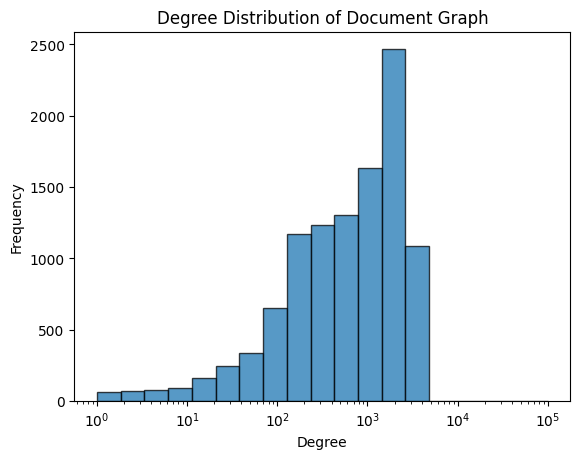

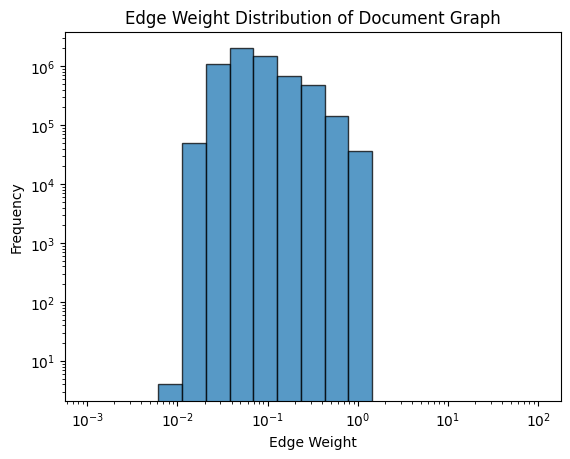

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Degree distribution
degree_sequence = [d for n, d in docGraph.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 5, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of Document Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [docGraph[u][v]['weight'] for u, v in docGraph.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-3, 2, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of Document Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()


> - `Distribution of degree` which show that there are many document node that has degree up to 1000 which mean they are highly connected mostly  
> - `Distribution of edge weight` show that there are even around almost 1000 node has attain weight close to 1which mean there quiet among number of document that has strong similarity within each other.  
> - This mean that the presence number of **supernodes**(node with large degrees) are highly connected.  

> !! finding: the edge weight distribution shows the Jaccard index's tendency to attain values close to 1, which are much larger than the ones we observed in the entity-entity graph.  


> It can be convenient to store all the edges in a DataFrame so that we can **plot them and then use them to filter and, thus, create a subgraph:**

In [90]:
documentGraph=docGraph
allEdgesWeights = pd.Series({
 (d[0], d[1]): d[2]["weight"] 
 for d in documentGraph.edges(data=True)
})


> Since we want to filter out edges weight of the graph, so we going to focus on hight weight edges, because hight weight of edges meaning they have strong relationship within each other. and those with low weight might mean they has low similarity or not strong relationship or they might be noise connection that make the analysis hardly to interpret. so we going to focus on meaningful relationship here... and keeping threashold at 0.6 might be a good one.

In [91]:
filteredDocumentGraph = documentGraph.edge_subgraph(
 allEdgesWeights[(allEdgesWeights>0.6)].index.tolist())
print(filteredDocumentGraph)


Graph with 3003 nodes and 54934 edges


> Than after this we going to look to the filter document distribution

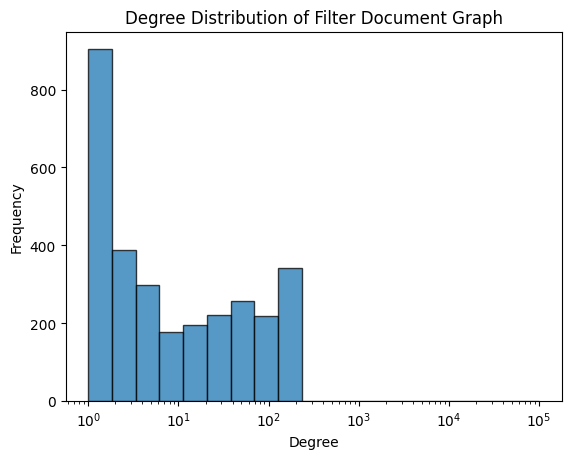

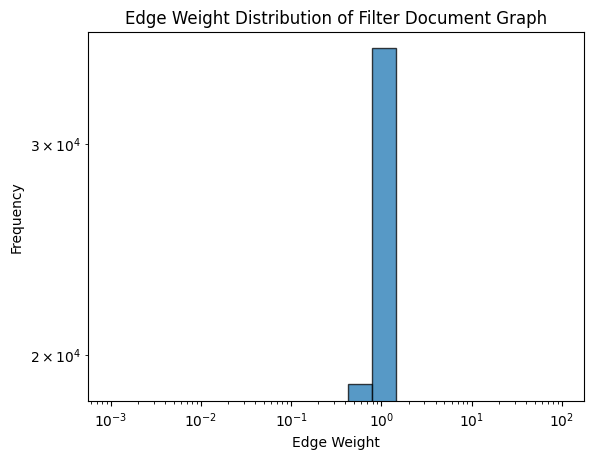

In [92]:
# Degree distribution
degree_sequence = [d for n, d in filteredDocumentGraph.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 5, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of Filter Document Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [filteredDocumentGraph[u][v]['weight'] for u, v in filteredDocumentGraph.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-3, 2, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of Filter Document Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()

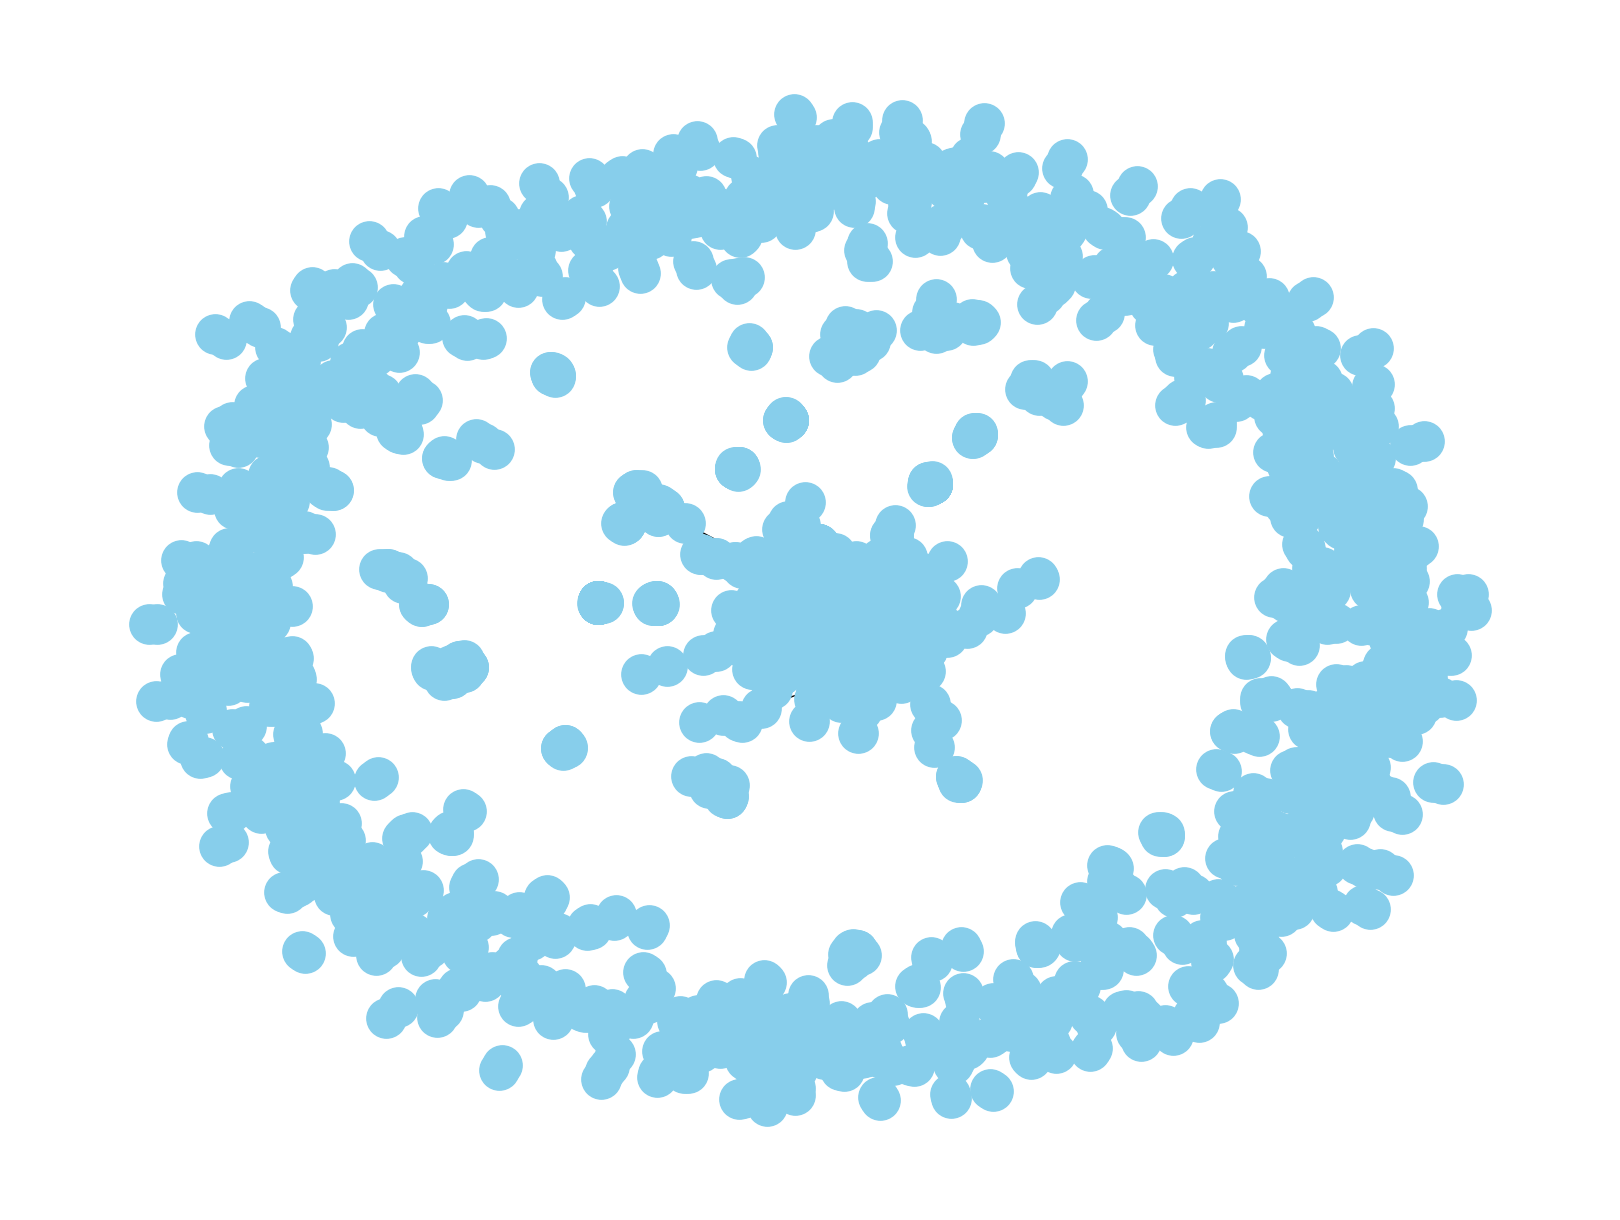

In [93]:
# Filtered subgraph creation
filtered_edges = allEdgesWeights[allEdgesWeights > 0.6].index.tolist()
filteredDocumentGraph = docGraph.edge_subgraph(filtered_edges)


# Visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(filteredDocumentGraph)  # You can choose a different layout algorithm
nx.draw(filteredDocumentGraph, pos, with_labels=False, font_weight='bold', node_color='skyblue', node_size=800, font_size=10)

# # Draw edge labels
# labels = nx.get_edge_attributes(filteredDocumentGraph, 'weight')
# nx.draw_networkx_edge_labels(filteredDocumentGraph, pos, edge_labels=labels)

plt.show()

>the document-document network is characterized by a core network and several connected satellites. These satellites represent all the documents that share none or a few keywords or entity common occurrences

In [94]:
components = pd.Series({
 ith: component 
 for ith, component in enumerate(
 nx.connected_components(filteredDocumentGraph)
 )
})

components

0      {8194, 6149, 4102, 4103, 4109, 8205, 16, 4113,...
1                                                {61, 5}
2                                           {8182, 8199}
3      {5793, 8200, 4745, 6707, 5846, 5686, 7610, 873...
4      {2561, 2562, 7169, 3588, 8203, 5136, 8729, 361...
                             ...                        
516                                         {7673, 7743}
517                                         {7678, 7791}
518                                         {7957, 7782}
519                                         {8142, 8094}
520                                         {8100, 8158}
Length: 521, dtype: object

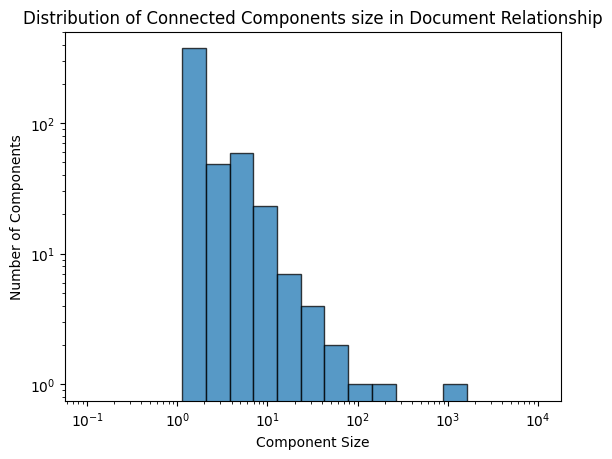

In [95]:
plt.hist(components.apply(len), bins=np.logspace(-1, 4, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Component Size')
plt.ylabel('Number of Components')
plt.title('Distribution of Connected Components size in Document Relationship')
plt.show()

> Here we can see the present a large cluster (the core) together with many small sized community (represent the periphery that consist of document around 100)

In [96]:
coreDocumentGraph = nx.subgraph(
 filteredDocumentGraph,
 [node 
 for nodes in components[components.apply(len)>100].values
 for node in nodes]
)
print(coreDocumentGraph)

Graph with 1279 nodes and 47531 edges


In [97]:
# Find connected components
components1 = list(nx.connected_components(filteredDocumentGraph))
# Sort components based on the number of nodes in descending order
sorted_components = sorted(components1, key=len, reverse=True)

# Extract the top 3 components
top_3_components = sorted_components[:10]

# Create subgraphs for the top 3 components
top_3_subgraphs = [filteredDocumentGraph.subgraph(component).copy() for component in top_3_components]

# Print the original index and number of nodes in each of the top 3 components
for i, (index, component) in enumerate(zip(range(1, 11), top_3_components), start=1):
    original_index = components1.index(component)
    print(f"Top {i} Component ( {original_index}): Number of Nodes = {len(component)}")

Top 1 Component ( 0): Number of Nodes = 994
Top 2 Component ( 19): Number of Nodes = 180
Top 3 Component ( 4): Number of Nodes = 105
Top 4 Component ( 8): Number of Nodes = 68
Top 5 Component ( 5): Number of Nodes = 52
Top 6 Component ( 44): Number of Nodes = 34
Top 7 Component ( 12): Number of Nodes = 33
Top 8 Component ( 135): Number of Nodes = 29
Top 9 Component ( 41): Number of Nodes = 24
Top 10 Component ( 55): Number of Nodes = 23


In [98]:
print("=====CoreDocumentGraph=====")
print("Number of nodes:", coreDocumentGraph.number_of_nodes())
print("Number of edges:", coreDocumentGraph.number_of_edges())
print("Average degree:", sum(dict(coreDocumentGraph.degree()).values()) / coreDocumentGraph.number_of_nodes())

=====CoreDocumentGraph=====
Number of nodes: 1279
Number of edges: 47531
Average degree: 74.32525410476936


> If we look up to only that big core component

In [99]:
# Find connected components
components2 = list(nx.connected_components(filteredDocumentGraph))

# Identify the largest connected component
largest_component = max(components2, key=len)

# Extract the subgraph corresponding to the largest component
coreDocumentGraph1 = filteredDocumentGraph.subgraph(largest_component).copy()

In [100]:
print(coreDocumentGraph1)

Graph with 994 nodes and 25961 edges


In [101]:
print("=====The Only Core DocumentGraph=====")
print("Number of nodes:", coreDocumentGraph1.number_of_nodes())
print("Number of edges:", coreDocumentGraph1.number_of_edges())
print("Average degree:", sum(dict(coreDocumentGraph1.degree()).values()) / coreDocumentGraph.number_of_nodes())

=====The Only Core DocumentGraph=====
Number of nodes: 994
Number of edges: 25961
Average degree: 40.59577795152463


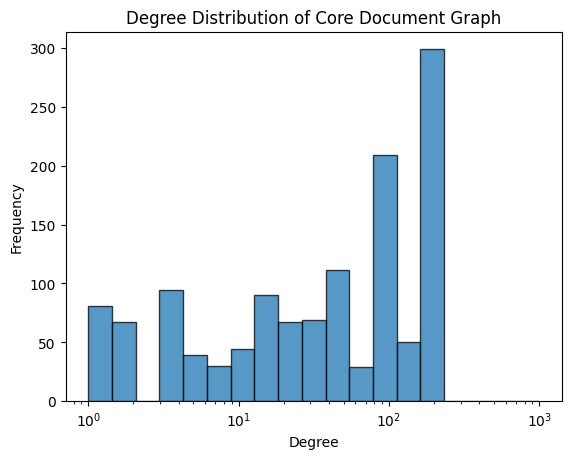

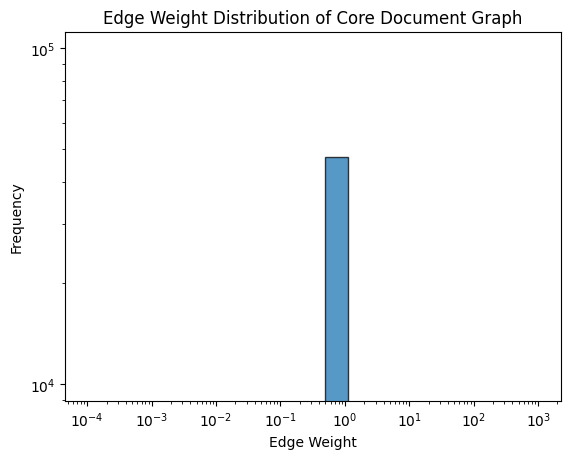

In [102]:
# Degree distribution
degree_sequence = [d for n, d in coreDocumentGraph.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of Core Document Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [coreDocumentGraph[u][v]['weight'] for u, v in coreDocumentGraph.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-4, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of Core Document Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()

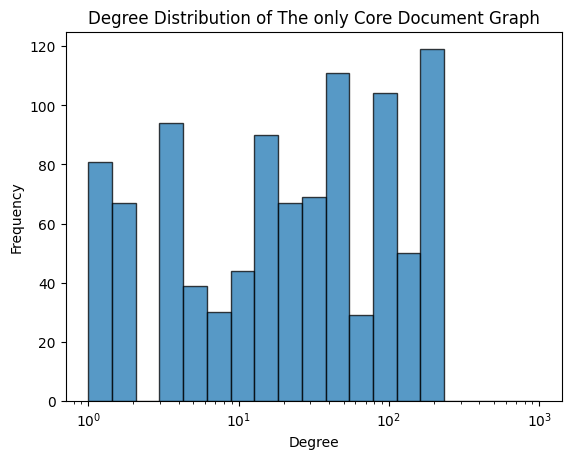

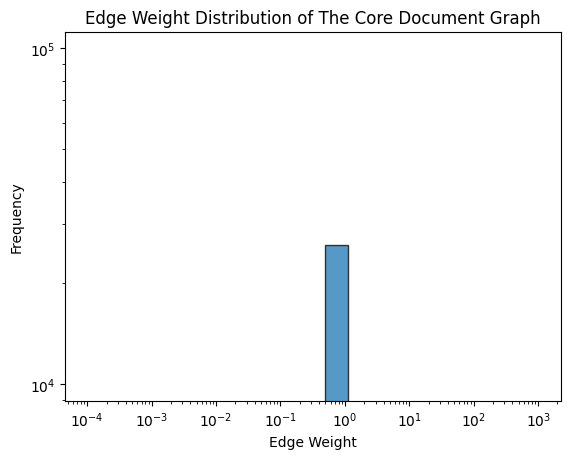

In [103]:
# Degree distribution
degree_sequence = [d for n, d in coreDocumentGraph1.degree()]
plt.hist(degree_sequence, bins=np.logspace(0, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.title("Degree Distribution of The only Core Document Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Edge weight distribution
edge_weight_sequence = [coreDocumentGraph1[u][v]['weight'] for u, v in coreDocumentGraph1.edges()]
plt.hist(edge_weight_sequence, bins=np.logspace(-4, 3, 20), alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title("Edge Weight Distribution of The Core Document Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.show()

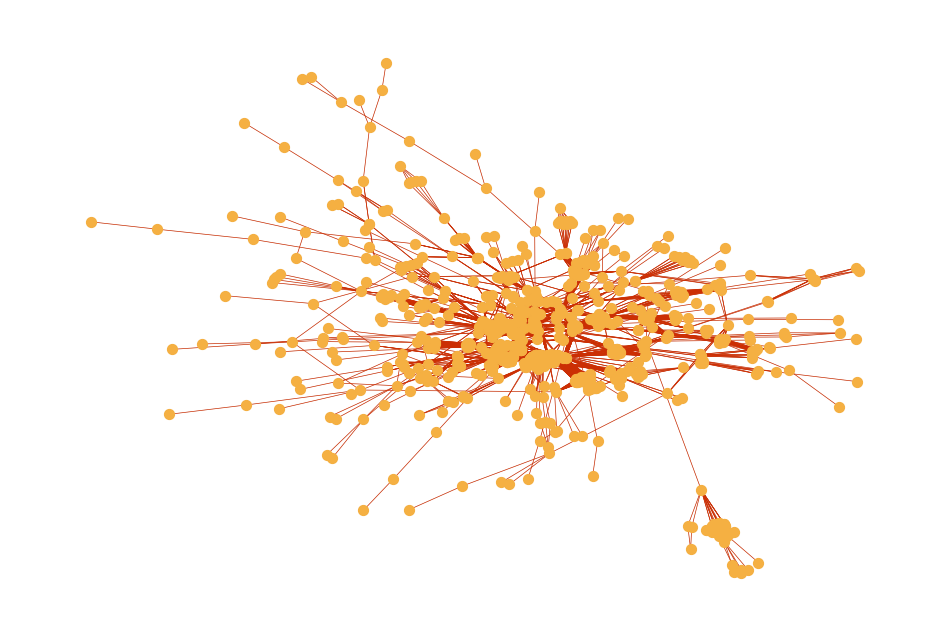

In [104]:

# Create network layout for visualizations
spring_pos = nx.spring_layout(coreDocumentGraph1)
default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

# Increase figure size for a larger visualization
plt.figure(figsize=(12, 8))

# Customize node and edge parameters for better visibility
nx.draw_networkx(coreDocumentGraph1, pos=spring_pos, node_color=default_node_color, 
                 edge_color=default_edge_color, with_labels=False, node_size=50, font_size=8, font_color='black',
                 alpha=0.7, linewidths=0.1, width=0.1)

# Highlight nodes and edges with enhanced colors
nx.draw_networkx_nodes(coreDocumentGraph1, pos=spring_pos, node_color=enhanced_node_color, node_size=50)
nx.draw_networkx_edges(coreDocumentGraph1, pos=spring_pos, edge_color=enhanced_edge_color, width=0.5)

# Display the plot without axis
plt.axis("off")

# Show the plot
plt.show()


> - the core composed of a community along with node that has different degree vary from each other but still strong weight which is not fairly large and strong weight edges like the book..  
> - which mean that the core document conponent consist of node document with strong similarity, on average the node connect to 40 other node by edges calculate with jaccard similarity.

In [105]:
communities=nx.community.louvain_communities(filteredDocumentGraph)
# Print the communities
for i, community in enumerate(list(communities)):
    print(f"Community {i + 1}: {community}")

Community 1: {5793, 8200, 4745, 6707, 5686, 5846, 7610, 8733, 7550, 9503}
Community 2: {2561, 2562, 2307, 3588, 7169, 5384, 2312, 2826, 8203, 5389, 2318, 5136, 786, 8729, 2587, 3611, 4125, 10015, 2847, 5409, 6690, 5667, 10787, 5669, 2341, 3879, 1066, 7980, 3372, 7470, 10543, 8497, 2610, 6706, 2355, 3637, 2617, 5946, 2362, 8763, 5178, 66, 2370, 2372, 73, 5707, 5964, 2382, 5455, 2896, 2395, 348, 10086, 5479, 9320, 1127, 9322, 7783, 7530, 2420, 2677, 9078, 10358, 2934, 2425, 2433, 902, 7815, 2697, 2699, 3988, 2454, 3991, 2712, 155, 3740, 2717, 2718, 8607, 5279, 2466, 1194, 5557, 2744, 9656, 6075, 2747, 4029, 8382, 460, 9688, 1499, 3037, 7902, 7903, 2271, 2784, 6115, 2276, 5094, 2534, 9705, 2795, 8180, 3576}
Community 3: {7941, 3335, 4104, 647, 4105, 7563, 8204, 6159, 10767, 7443, 5913, 3356, 1180, 1181, 7584, 1185, 8358, 168, 10408, 2601, 5038, 5937, 7603, 4147, 9139, 1587, 3645, 1470, 4030, 1984, 10434, 9799, 7880, 9293, 8659, 8281, 7001, 3291, 9692, 4954, 2014, 222, 10716, 8543, 2400, 4

In [106]:
corpus.columns

Index(['id', 'text', 'label', 'clean_text', 'language', 'parsed', 'keywords'], dtype='object')

> Then, we will extract the topic mixture within each community to see whether there is a homogeneity (all the documents belonging to the same class) or some correlation between topics

In [107]:
from collections import Counter
import pandas as pd

def getTopicRatio(df):
    return Counter([label for labels in df["label"] for label in labels])

communityTopics = pd.DataFrame.from_dict({
    cid: getTopicRatio(corpus.loc[list(comm)])
    for cid, comm in enumerate(communities)
}, orient="index")

normalizedCommunityTopics = (communityTopics.T / communityTopics.sum(axis=1)).T

> - **getTopicRatio** function is designed to calculate the ratio of different topics within a community  
> - **communityTopics** should be a DataFrame where each row corresponds to a community, and the columns represent the topic mixture for each community.  
> - **normalizedCommunityTopics** is a DataFrame that, for each community (row in the DataFrame), provides the topic mixture (in percentage) of the different topics (along the column axis)

In [108]:
corpus

,id,text,label,clean_text,language,parsed,keywords
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],asian exporters fear damage from u.s.-japan ri...,en,"(asian, exporters, fear, damage, from, u.s.-ja...","[(trading, 0.461513063953854), (said, 0.315985..."
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],china daily says vermin eat 7-12 pct grain sto...,en,"(china, daily, says, vermin, eat, 7, -, 12, pc...","[(vermin, 0.3120614380287181), (daily, 0.26110..."
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",japan to revise long-term energy demand downwa...,en,"(japan, to, revise, long, -, term, energy, dem...","[(energy demand, 0.3668609094700038), (nuclear..."
3,test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",thai trade deficit widens in first quarter th...,en,"(thai, trade, deficit, widens, in, first, quar...","[(pct, 0.5457455609144308), (export, 0.2656069..."
4,test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",indonesia sees cpo price rising sharply indon...,en,"(indonesia, sees, cpo, price, rising, sharply,...","[(indonesia, 0.24104282355029355), (harahap, 0..."
...,...,...,...,...,...,...,...
10783,training/999,U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...,"[interest, money-fx]",u.k. money market shortage forecast revised do...,en,"(u.k, ., money, market, shortage, forecast, re...","[(forecast, 0.3364640504513789), (market, 0.33..."
10784,training/9992,KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY Qtl...,[earn],knight-ridder inc &lt;krn> sets quarterly qtl...,en,"(knight, -, ridder, inc, &, lt;krn, >, sets, q...","[(sets, 0.33086349685229777), (april, 0.330863..."
10785,training/9993,TECHNITROL INC &lt;TNL> SETS QUARTERLY Qtly d...,[earn],technitrol inc &lt;tnl> sets quarterly qtly d...,en,"(technitrol, inc, &, lt;tnl, >, sets, quarterl...","[(april, 0.4784248004558349), (sets, 0.3366439..."
10786,training/9994,NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...,[earn],nationwide cellular service inc &lt;ncel> 4th ...,en,"(nationwide, cellular, service, inc, &, lt;nce...","[(shrs, 0.48295618305741034), (loss, 0.4437435..."


In [109]:
communityTopics.head()

,earn,money-fx,interest,housing,trade,dlr,yen,money-supply,cpi,ship,...,veg-oil,coconut-oil,instal-debt,tea,rapeseed,nickel,palladium,platinum,orange,lumber
0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
normalizedCommunityTopics.head()

,earn,money-fx,interest,housing,trade,dlr,yen,money-supply,cpi,ship,...,veg-oil,coconut-oil,instal-debt,tea,rapeseed,nickel,palladium,platinum,orange,lumber
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
columns_with_mean_one = normalizedCommunityTopics.columns[normalizedCommunityTopics.mean() > 0.8]

# Print columns with mean value equal to 0.8
for column in columns_with_mean_one:
    print(column)


earn
acq
jobs
gold
cotton
tin
orange
lumber


> To quantify the heterogeneity of the topic mixture within the clusters/communities, we must compute the `Shannon entropy` of each community:  
$$
{I_{c}}= -\sum{\log{t_{ci}}}
$$  
- $I_{c}$ represents the entropy of the cluster.  
- $t_{ci}$ is the percentage of topic i in community c.  
  
> **Note**: Heterogenity mean the maxture of different topic within a communities


In [112]:
normalizedCommunityTopics.apply(
 lambda x: np.sum(-np.log(x)), axis=1)

0      0.0
1      0.0
2      0.0
4      0.0
5      0.0
      ... 
354    0.0
401    0.0
444    0.0
487    0.0
515    0.0
Length: 534, dtype: float64

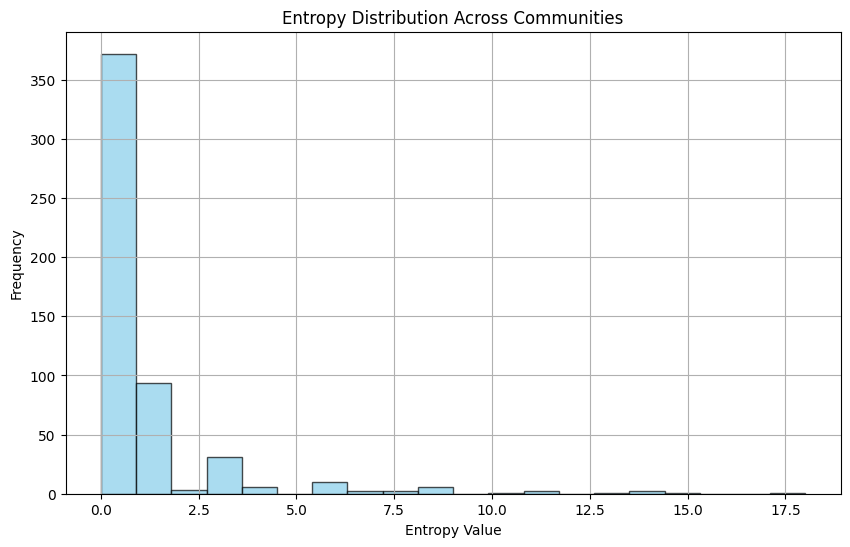

In [113]:
# Calculate the sum of negative logarithms for each row
entropy_values = normalizedCommunityTopics.apply(lambda x: np.sum(-np.log(x)), axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(entropy_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Entropy Value')
plt.ylabel('Frequency')
plt.title('Entropy Distribution Across Communities')
plt.grid(True)
plt.show()

> Most communities have zero or very low entropy, thus suggesting that the documents that belong to the same class (label) tend to cluster together

> Next we will investigate whether there is a relationship between topics, when communities show some heterogeneity. Namely, we compute the correlation between topic distributions

In [114]:
topicsCorrelation = normalizedCommunityTopics.corr().fillna(0)

In [115]:
topicsCorrelation.head()

,earn,money-fx,interest,housing,trade,dlr,yen,money-supply,cpi,ship,...,veg-oil,coconut-oil,instal-debt,tea,rapeseed,nickel,palladium,platinum,orange,lumber
earn,1.000000,0.000000,-0.174343,0.0,-1.000000,0.000000,0.000000,-1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
money-fx,0.000000,1.000000,-0.602782,0.0,0.577653,0.409801,0.557364,-0.601495,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
interest,-0.174343,-0.602782,1.000000,0.0,1.000000,-0.802454,0.000000,0.369230,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
housing,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trade,-1.000000,0.577653,1.000000,0.0,1.000000,-0.181369,0.000000,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


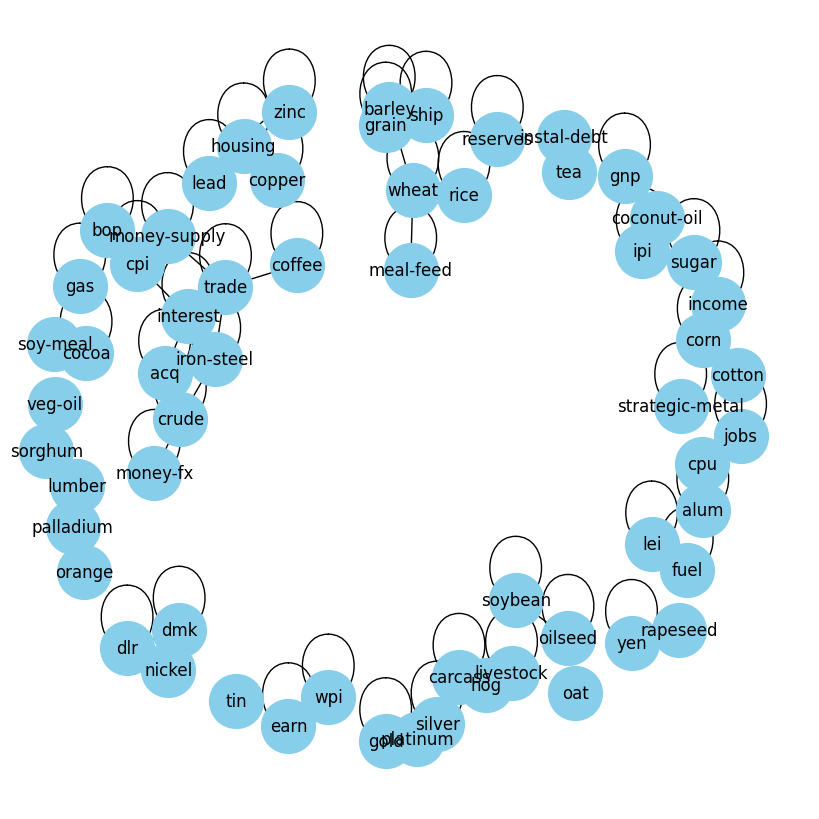

In [116]:
topicsCorrelation = normalizedCommunityTopics.corr().fillna(0)
topicsCorrelation[topicsCorrelation<0.8]=0

topicsGraph = nx.from_pandas_adjacency(topicsCorrelation)
plt.figure(figsize=(8,8))

pos = nx.spring_layout(topicsGraph, k=0.35) # k regulates the distance between nodes

nx.draw(topicsGraph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)

# plt.show()
# plt.savefig(os.path.join(".", "TopicsAll.png"), dpi=300, format="png")

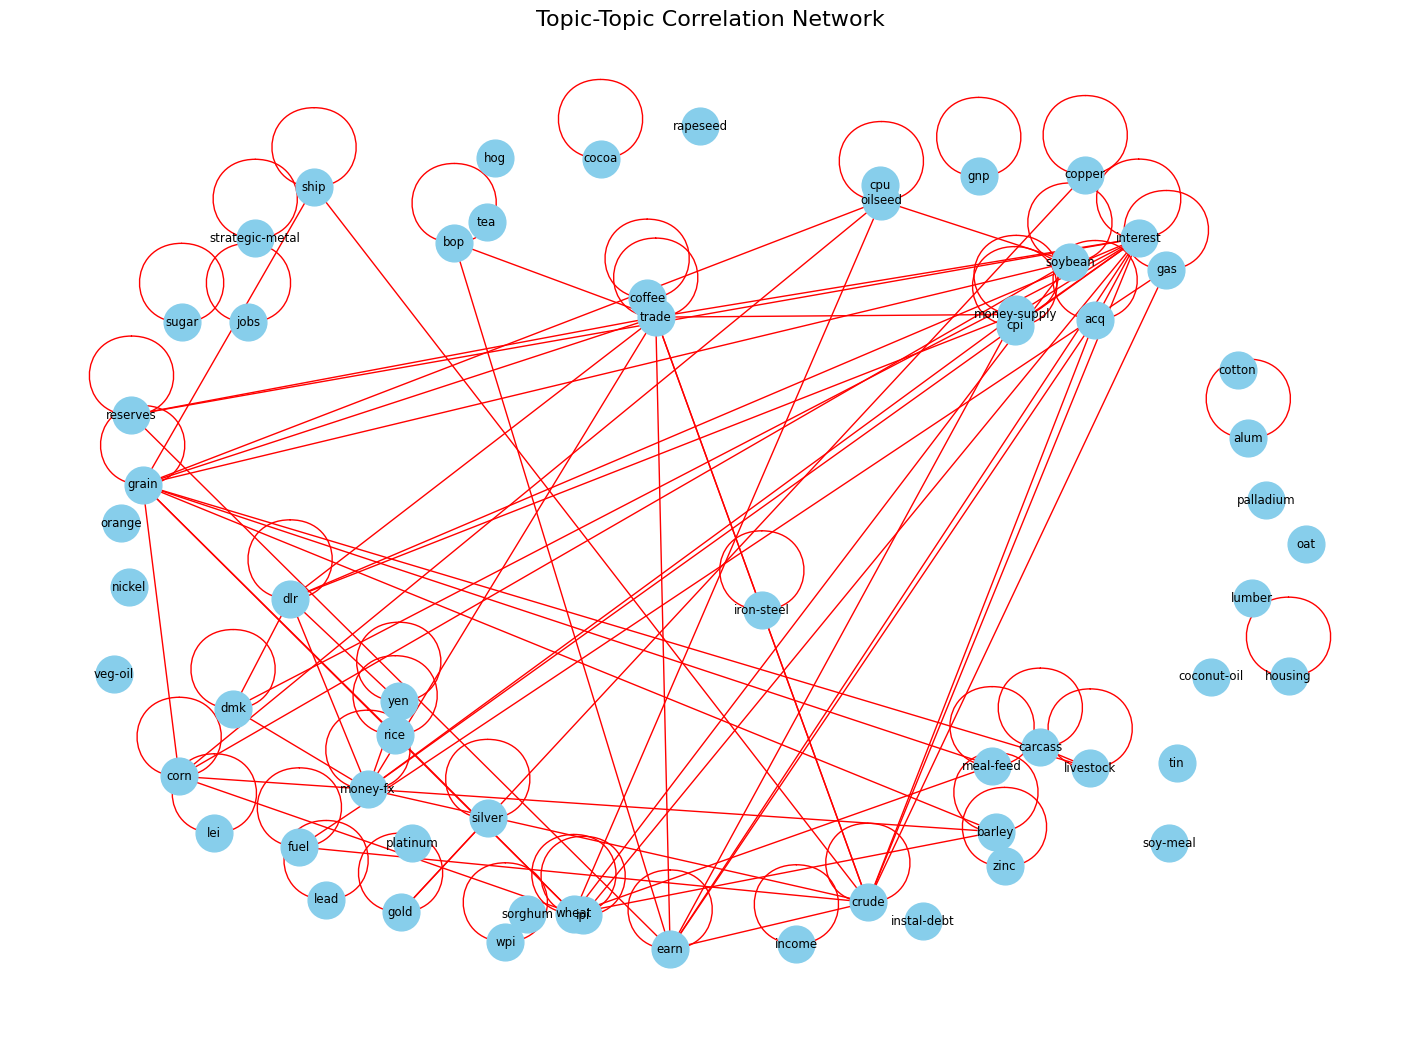

In [117]:
# Create a graph using the correlation matrix
G = nx.from_pandas_adjacency(normalizedCommunityTopics.corr().fillna(0))
# Draw the entire graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8.5, font_color='black', node_size=700, node_color='skyblue', edge_color='red', width=1)
plt.title('Topic-Topic Correlation Network', fontsize=16)
plt.show()


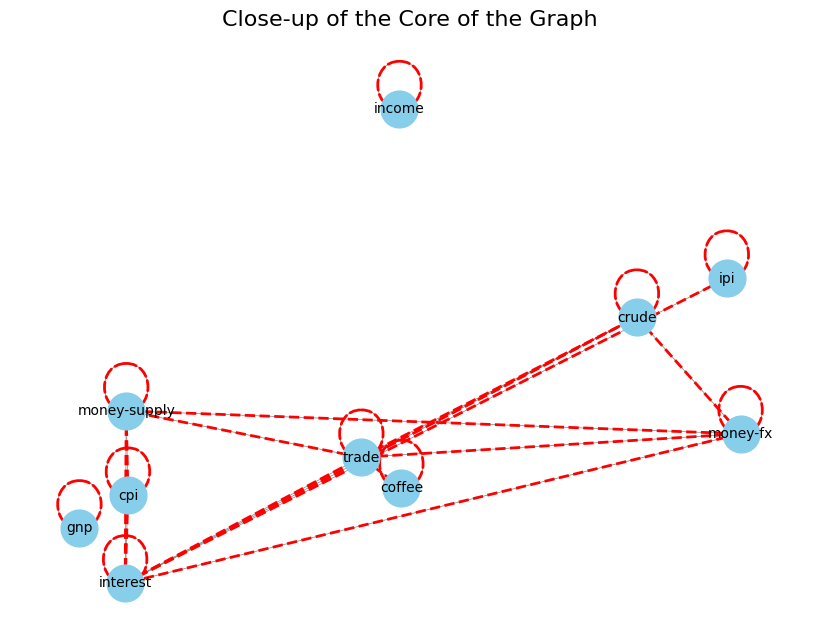

In [118]:
# Draw a close-up of the core of the graph
plt.figure(figsize=(8, 6))
core_nodes = ['money-fx', 'crude', 'income', 'coffee', 'trade', 'money-supply', 'interest', 'ipi','gnp','cpi']
core_edges = [(u, v) for u, v in G.edges() if u in core_nodes and v in core_nodes]

core_pos = nx.spring_layout(G.subgraph(core_nodes), seed=42)
nx.draw(G.subgraph(core_nodes), core_pos, with_labels=True, font_size=10, font_color='black', node_size=700, node_color='skyblue', edge_color='gray', width=0.5)
nx.draw_networkx_edges(G, core_pos, edgelist=core_edges, width=2, edge_color='red', style='dashed')

plt.title('Close-up of the Core of the Graph',fontsize=16)
plt.show()


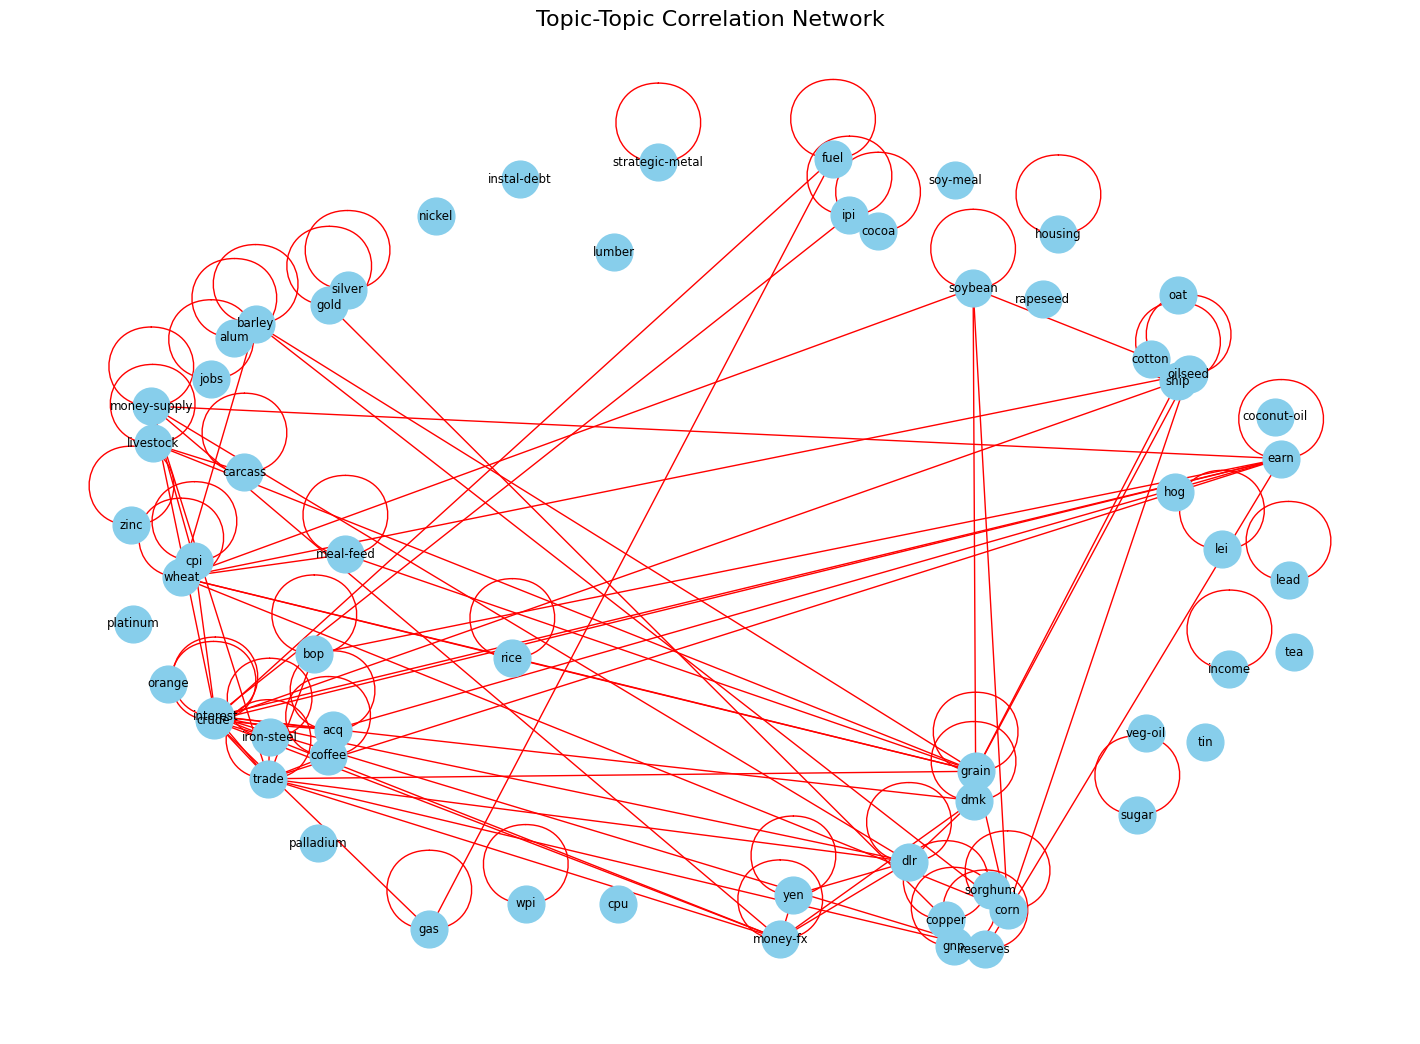

In [119]:
# Create a graph using the correlation matrix
G1 = nx.from_pandas_adjacency(normalizedCommunityTopics.corr().fillna(0))
# Draw the entire graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, font_size=8.5, font_color='black', node_size=700, node_color='skyblue', edge_color='red', width=1)
plt.title('Topic-Topic Correlation Network', fontsize=16)
plt.show()


> - the topic-topic graph shows a structure organized in a periphery of disconnected nodes and a strongly connected core.  
> - This indicates a correlation that is supported by a semantic meaning, with the topics related to commodities tightly connected to each other: